In [0]:
# !kill -9 -1

In [81]:
# !cat /proc/cpuinfo
!nvidia-smi


Sat Jun 29 13:58:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |    419MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
import keras
from pandas.core.frame import DataFrame
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import csv
import datetime
from sklearn.model_selection import train_test_split
%matplotlib inline

## upload data

#### please upload all.csv

In [30]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all.csv


## read csv

In [0]:
def readTrain():
  train = pd.read_csv("all.csv")
  return train

In [0]:
#read data
train = readTrain()

## give data column
#### time : 2016~2019
#### WS :windspeed
#### WD: winddirect
#### temp: tempture
#### DTR : value(we have to validation this)

In [0]:
trainnp = train.values
train1 = pd.DataFrame(trainnp)
train1.columns = ['time','WS','WD','temp','DTR']

In [86]:
train1[0:5]

,time,WS,WD,temp,DTR
0,2016/1/26 00:00,2.9,59.8,2.9,1706.64
1,2016/1/26 01:00,2.9,53.1,2.9,1708.52
2,2016/1/26 02:00,3.3,49.7,3.3,1772.53
3,2016/1/26 03:00,3.5,53.9,3.5,1807.66
4,2016/1/26 04:00,3.5,55,3.5,1813.4


## Completion of continuous time missing and data missing 

#### the origial data has a lot of NAN and -1,and continuous time missing, we have to fix it



In [0]:
def makeTime(train):
  train['time'] = pd.to_datetime(train['time'])
  grouper = pd.Grouper(key='time', freq='60T')
  res = train.groupby(grouper).first().reset_index()
  res = res.fillna(method="ffill") # propagate non-null values forward
  return res


In [0]:
trainTime = makeTime(train1)

In [0]:
trainTime[14814:14822]

## add feature

####The original field has only four features, wind speed, time, wind direction and temperature. For our prediction of DTR, there are very few features, so we have to divide the time into months, date,day of week and hour

In [0]:
def augFeatures(train):
  train["time"] = pd.to_datetime(train["time"])
#   train["year"] = train["time"].dt.year
  train["month"] = train["time"].dt.month
  train["date"] = train["time"].dt.day
  train["dayofweek"] = train["time"].dt.dayofweek
  train["hour"] = train["time"].dt.hour
  return train

In [0]:
train_Aug = augFeatures(trainTime)

In [94]:
train_Aug[0:5]

,time,WS,WD,temp,DTR,month,date,dayofweek,hour
0,2016-01-26 00:00:00,2.9,59.8,2.9,1706.64,1,26,1,0
1,2016-01-26 01:00:00,2.9,53.1,2.9,1708.52,1,26,1,1
2,2016-01-26 02:00:00,3.3,49.7,3.3,1772.53,1,26,1,2
3,2016-01-26 03:00:00,3.5,53.9,3.5,1807.66,1,26,1,3
4,2016-01-26 04:00:00,3.5,55.0,3.5,1813.40,1,26,1,4


## drop time column

In [0]:
def dropSomething(train):
  train = train.drop(["time"], axis=1)

  return train

In [0]:
train_drop = dropSomething(train_Aug)

## replace -1 to NULL

In [0]:
trainnon = train_drop.replace({'WS':-1,'WD':-1,'temp':-1,'DTR':-1},np.nan)

## feature scaling

In [0]:
def normalize(train):
  train_norm = train.apply(lambda x: (x - np.nanmean(x)) / (np.max(x) - np.min(x)))
  return train_norm

In [0]:
train_norm = normalize(trainnon)

## slice data(predicting 6 data by the first 24 data)

In [0]:
#predicting ? data by the first ? data
def buildTrain(train, pastDay, futureDay):
  X_train, Y_train = [], []
  #cut pastDay and futureDay can get range
  for i in range(train.shape[0]-futureDay-pastDay):
    a = train.iloc[i:i+pastDay]
#     a = a.drop(["DTR"], axis=1)
    b = train.iloc[i+pastDay:i+pastDay+futureDay]["DTR"]
    #check data and drop NULL data
    if a.isnull().values.any() or b.isnull().values.any():
      continue
    else:
      X_train.append(np.array(a))
      Y_train.append(np.array(b))
  return np.array(X_train),np.array(Y_train)

In [0]:
X_all, Y_all = buildTrain(train_norm, 24, 6)

### X_all : data feature
### Y_all : data result

In [102]:
print(X_all.shape)
print(Y_all.shape)

(23715, 24, 8)
(23715, 6)


## put out some  data (no  training, no validation, just strange data)

In [0]:
X_train = X_all[:22240]
Y_train = Y_all[:22240]
X_validate = X_all[22241:]
Y_validate = Y_all[22241:]

In [104]:
print(X_train.shape)

(22240, 24, 8)


## random slice data to train data and validation data

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(18904, 24, 8)
(18904, 6)
(3336, 24, 8)
(3336, 6)


## reshape (Only For Many to Many model)

In [0]:
# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_test = Y_test[:,:,np.newaxis]

In [107]:
Y_test.shape

(3336, 6, 1)

## build model

In [0]:
#many to many(same sequence length)
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(128, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mae", optimizer="adam")
  model.summary()
  return model

In [0]:
#many to many (different sequence length)
def buildManyTodifManyModel(shape):
  model = Sequential()  
  model.add(LSTM(input_length=shape[1],input_dim=shape[2], output_dim=300, return_sequences=False))  
  model.add(Dropout(0.2))
  model.add(RepeatVector(6))
  model.add(LSTM(output_dim=300, return_sequences=True))  
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
#   model.add(Activation('linear'))   
  model.compile(loss='mse', optimizer='adam') 
  model.summary()
  return model

In [0]:
#many to one
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(300, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(Dropout(0.2))
#   model.add(LSTM(256, return_sequences=True))
#   model.add(Dropout(0.2))
  model.add(LSTM(300, return_sequences=False))
  model.add(Dropout(0.2))
  # output shape: (1, 1)
#   model.add(Dense(512))
#   model.add(Dropout(0.2))
#   model.add(Dense(256))
#   model.add(Dropout(0.2))
#   model.add(Dense(128))
#   model.add(Dropout(0.2))
  model.add(Dense(1))
  adam = keras.optimizers.Adam(lr = 0.0001)
  model.compile(loss="mae", optimizer=adam)
  model.summary()
  return model

In [109]:
#many to many(same sequence length)
# model = buildManyToManyModel(X_train.shape)
#many to many(different sequence length)
model = buildManyTodifManyModel(X_train.shape)
# many to one
# model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="val_loss",min_delta=0.0001, patience=15,verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=50, batch_size=128, validation_data=(X_test, Y_test),callbacks=[callback]) #callbacks=[callback]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(24, 8), units=300)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=300)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300)               370800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 300)            721200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              301       
Total params: 1,092,301
Trainable params: 1,092,301
Non-trainable params: 0
_________________________________________________________________


## Show training history

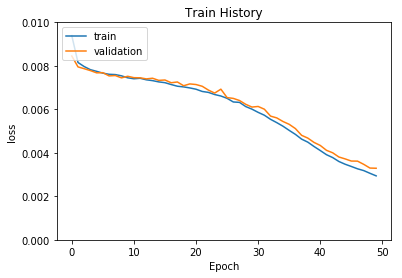

In [113]:
import matplotlib.pyplot as plt

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0,0.01])
    plt.show()

show_train_history(history,'loss','val_loss')

## Load strange data and view forecast results

In [78]:
# results = np.argmax(model.predict(X_test)) #forcast
results = (model.predict(X_validate)) #forcast
print(results[0])
print(Y_validate[0])

[[-0.13010931]
 [-0.11443662]
 [-0.11148709]
 [-0.10864223]
 [-0.10690326]
 [-0.10580356]]
[-0.05752437 -0.08640642 -0.12817568 -0.18964312 -0.18367111 -0.31524379]


## Calculate the maximum and average error values (for many to on)

In [0]:
d = 0
list5 = []
list6 = []
list7 = []

for i in range(Y_validate.shape[0]):
  #a:test data result  b:predict data
  a = Y_validate[i]*(np.max(trainnon['DTR']) - np.min(trainnon['DTR'])) + np.nanmean(trainnon['DTR'])
  b = results[i]*(np.max(trainnon['DTR']) - np.min(trainnon['DTR'])) + np.nanmean(trainnon['DTR'])
  list6.append(a)
  list7.append(b)
  e = abs(b-a)
  g = 0
  list5.append(e)
  global d
  d += e
print('validation')
print('Mean error value:{}'.format(d[0]/len(list6)))  
print('Maximum error value:{}'.format(max(list5)[0]))

## Calculate the maximum and average error values (for many to many)

In [114]:
d = 0
list5 = []
list6 = []
list7 = []
list8 = []
list9 = []

for i in range(Y_validate.shape[0]):

  a = Y_validate[i]*(np.max(trainnon['DTR']) - np.min(trainnon['DTR'])) + np.mean(trainnon['DTR'])
  b = results[i]*(np.max(trainnon['DTR']) - np.min(trainnon['DTR'])) + np.mean(trainnon['DTR'])
  list8.append(np.mean(a))
  list9.append(np.mean(b))
  for h in range(6):
    list6.append(a[h])
    list7.append(b[h][0])
    list5.append(abs(a[h]-b[h][0]))

print('validation')
print('Mean error value:{}'.format(np.sum(list5)/len(list5)))
print('Maximum error value:{}'.format(max(list5)))

validation
Mean error value:224.62275263282098
Maximum error value:1062.7244726562403


## Draw a comparison of predicted and results(for many to on)

In [0]:
#FOR　many 2 one
plt.plot(listy6[200:300])
plt.plot(list7[200:300])
plt.title('validation')
plt.ylabel('DTR')
plt.xlabel('data')
plt.legend(['result', 'predict'], loc='upper left')
plt.ylim([500,2500])
plt.show()

## Draw a comparison of predicted and results(for many to many)

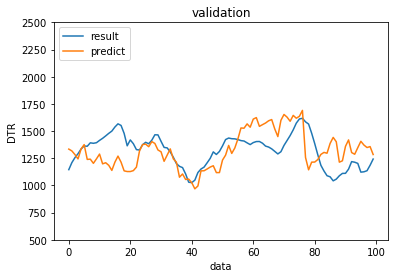

In [115]:
# For many 2 many
plt.plot(list8[400:500])
plt.plot(list9[400:500])
plt.title('validation')
plt.ylabel('DTR')
plt.xlabel('data')
plt.legend(['result', 'predict'], loc='upper left')
plt.ylim([500,2500])
plt.show()

## save model 

In [0]:
model.save('Keras_DTR_LSTM.h5')

## download model

In [0]:
from google.colab import files

files.download('Keras_DTR_LSTM.h5')